<a href="https://colab.research.google.com/github/kknowlson07/game_of_life/blob/master/NN_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  NOTE: if running in Colab, remember to change the runtime to GPU

In [2]:
!pip install torchtext==0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00


In [3]:
import torch
from torchtext import data, datasets
from torchtext.data import Field, LabelField
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import spacy

# Define the fields using the updated torchtext
# Load the spaCy model
spacy_model = 'en_core_web_sm'
spacy_en = spacy.load(spacy_model)

# Define the Field using the spaCy tokenizer
TEXT = Field(tokenize=lambda text: [tok.text for tok in spacy_en.tokenizer(text)], include_lengths=True)
LABEL = LabelField(dtype=torch.float)


# Load the IMDb dataset
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

# Split the data into training and validation sets
train_data, valid_data = train_data.split(split_ratio=0.8)


downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:12<00:00, 6.92MB/s]


In [4]:
# print the first example in training
print(vars(train_data.examples[0]))

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)


print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

{'text': ['This', 'film', 'has', 'all', 'the', 'earmarks', 'of', 'too', 'many', 'cooks', 'spoiling', 'the', 'stew', '.', 'Based', 'on', 'Shielah', 'Graham', "'s", 'autobiography', ',', 'it', 'seems', 'like', 'the', 'powers', 'that', 'be', 'could', "n't", 'leave', 'well', 'enough', 'alone', '.', 'They', 'could', "n't", 'decide', 'if', 'this', 'was', 'to', 'be', 'Graham', "'s", 'story', 'or', 'Fitzgerald', "'s", 'story', ',', 'and', 'also', 'how', 'much', 'they', 'should', 'soft', '-', 'pedal', 'whoever', "'s", 'story', 'it', 'turned', 'out', 'to', 'be', '.', 'So', 'a', 'film', 'that', 'could', 'have', 'been', 'a', 'story', 'about', 'two', 'fascinating', '(', 'Fitzgerald', ')', 'and', 'notorious', '(', 'Ms.', 'Graham)personalities', 'becomes', 'a', 'dreary', 'disjointed', 'soap', 'opera', 'about', 'that', 'tells', 'us', 'little', 'about', 'either', '.', 'Added', 'to', 'this', 'there', 'is', 'absolutely', 'no', 'period', 'feel', 'other', 'than', 'for', '1959', '.', 'Clumsy', 'scene', 'fol

In [5]:
# Define the Fully Connected Neural Network model
class FCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(FCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = embedded.sum(0)
        output = self.fc(embedded)
        return output


In [6]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, hidden = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = self.fc(output[-1])
        return output


In [7]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = self.fc(output[-1])
        return output




In [8]:
# Define GRU model
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, hidden = self.gru(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = self.fc(output[-1])
        return output





# Execute the specific model

In [12]:
## This is GRU- Choose Two Models: Train, evaluate, and compare two models

# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the training hyperparameters and model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 128
output_dim = 1


#model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)


# Adam optimizer
optimizer = optim.Adam(model.parameters())
#Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
criterion = nn.BCEWithLogitsLoss()
lossGRU = []
lossGRUVal = []
# Train and evaluate the model
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    lossGRU.append(train_loss)
    lossGRUVal.append(valid_loss)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')

# Test the model
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')


Epoch: 01, Train Loss: 0.691, Val. Loss: 0.689
Epoch: 02, Train Loss: 0.684, Val. Loss: 0.681
Epoch: 03, Train Loss: 0.678, Val. Loss: 0.675
Epoch: 04, Train Loss: 0.669, Val. Loss: 0.674
Epoch: 05, Train Loss: 0.662, Val. Loss: 0.667
Epoch: 06, Train Loss: 0.651, Val. Loss: 0.689
Epoch: 07, Train Loss: 0.650, Val. Loss: 0.662
Epoch: 08, Train Loss: 0.643, Val. Loss: 0.653
Epoch: 09, Train Loss: 0.634, Val. Loss: 0.655
Epoch: 10, Train Loss: 0.630, Val. Loss: 0.649
Test Loss: 0.523


In [11]:
## This is LSTM- Choose Two Models: Train, evaluate, and compare two models

# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the training hyperparameters and model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 128
output_dim = 1


#model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)


# Adam optimizer
optimizer = optim.Adam(model.parameters())
#Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
criterion = nn.BCEWithLogitsLoss()
lossLSTM = []
lossLSTMVal = []
# Train and evaluate the model
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    lossLSTM.append(train_loss)
    lossLSTMVal.append(valid_loss)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')

# Test the model
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')


Epoch: 01, Train Loss: 0.691, Val. Loss: 0.690
Epoch: 02, Train Loss: 0.693, Val. Loss: 0.692
Epoch: 03, Train Loss: 0.688, Val. Loss: 0.686
Epoch: 04, Train Loss: 0.680, Val. Loss: 0.690
Epoch: 05, Train Loss: 0.672, Val. Loss: 0.688
Epoch: 06, Train Loss: 0.665, Val. Loss: 0.682
Epoch: 07, Train Loss: 0.683, Val. Loss: 0.688
Epoch: 08, Train Loss: 0.674, Val. Loss: 0.678
Epoch: 09, Train Loss: 0.656, Val. Loss: 0.666
Epoch: 10, Train Loss: 0.654, Val. Loss: 0.673
Test Loss: 0.565


10


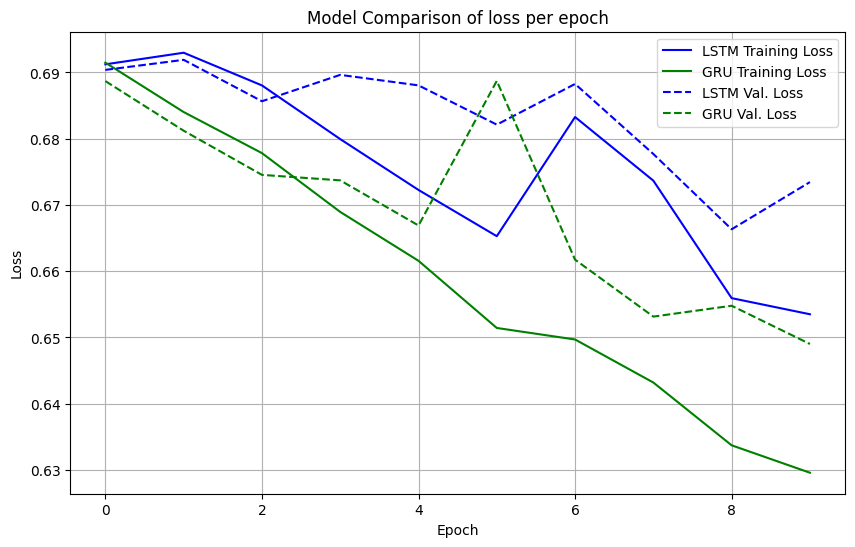

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
print(len(lossLSTM))
plt.plot(range(0, 10), lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(range(0, 10), lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(range(0, 10), lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(range(0, 10), lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Comparison of loss per epoch')
plt.legend()
plt.grid(True)
plt.show()

### Model Comparison of losses

As expected both varieties of loss decrease as the epoches increase. Its also expected to see the valid loss to be slightly higher than the training loss during this time, which is seen. The LSTM model, seen in blue, did not perform as well over all than did the GRU model, seen in green. From the first epoch, the GRU model outperforms by having a lower loss.

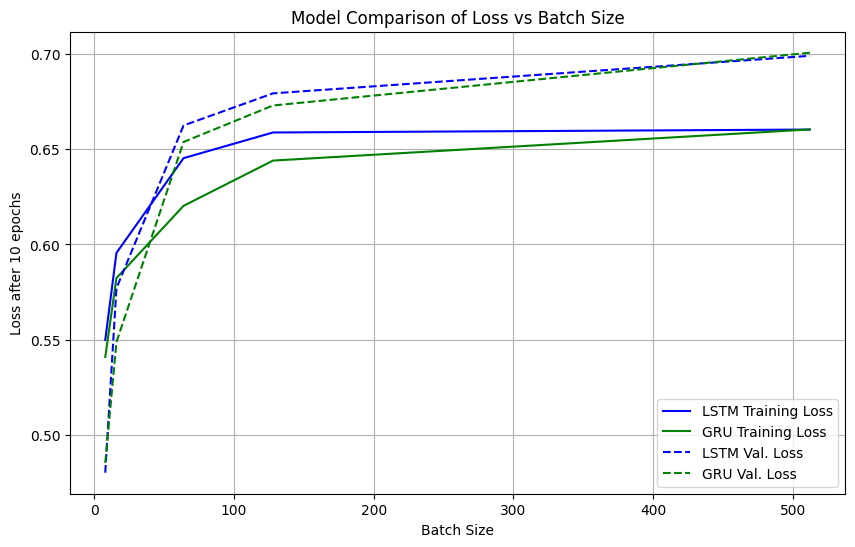

In [24]:
## Batches - Hyperparameter tuning
import matplotlib.pyplot as plt


# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
batches = [8, 16, 64, 128, 512]
for i in batches:
  # Define the iterators
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data),
      batch_size=i,
      sort_within_batch=True,
      device=device
  )

  # Define the training loop
  def train(model, iterator, optimizer, criterion):
      model.train()
      epoch_loss = 0
      iterator.create_batches()
      for batch in iterator:
          optimizer.zero_grad()
          text, text_len = batch.text
          predictions = model(text, text_len).squeeze(1)
          loss = criterion(predictions, batch.label)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      return epoch_loss / len(iterator)

  # Define the evaluation function
  def evaluate(model, iterator, criterion):
      model.eval()
      epoch_loss = 0
      iterator.create_batches()
      with torch.no_grad():
          for batch in iterator:
              text, text_len = batch.text
              predictions = model(text, text_len).squeeze(1)
              loss = criterion(predictions, batch.label)
              epoch_loss += loss.item()
      return epoch_loss / len(iterator)

  # Define the training hyperparameters and model
  input_dim = len(TEXT.vocab)
  embedding_dim = 200
  hidden_dim = 128
  output_dim = 1


  #model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  #model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)


  # Adam optimizer
  optimizer = optim.Adam(model.parameters())
  optimizer2 = optim.Adam(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()

  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))

plt.plot(batches, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(batches, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(batches, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(batches, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Batch Size')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Testing: Batch sizes


Here we are monitoring the final loss after ten epoches for each batch size. There appears to be a positive correlation between batch size and loss. Unfortunately this is not something we would want to see, so it would be better to use a smaller batch size. This is because the larger the batch size gets, the closer it is to not even using mini batches which means that the updates happen less frequently and generalization is reduced. The reduction in generalization is seen by how much greater the loss is in the valid error and the training error, particularily as the batch size grows large.

Again the GRU model continues to outperform the LSTM but both follow the same trend as it relates to batch sizes.

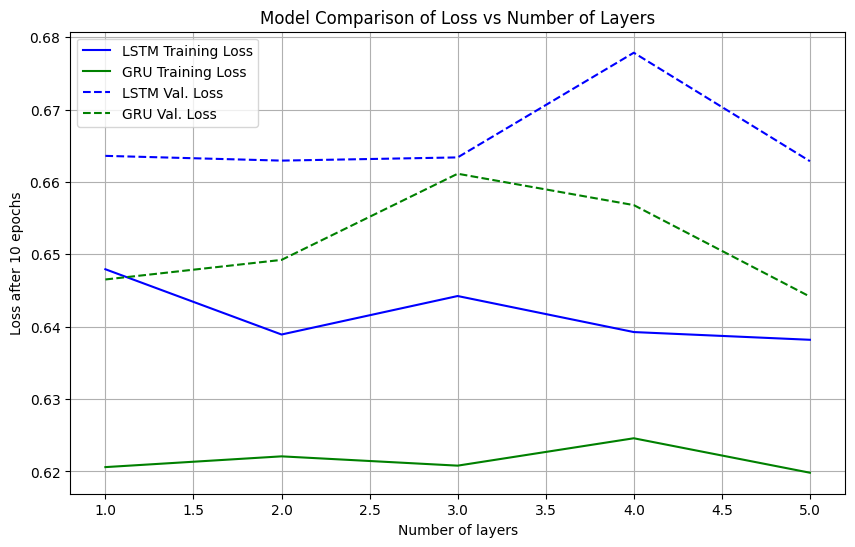

In [23]:
## Hidden layers number - Hyperparameter tuning
import matplotlib.pyplot as plt

# Define GRU model
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_layers = num_layers

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, hidden = self.gru(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = self.fc(output[-1])
        return output
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_layers = num_layers

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = self.fc(output[-1])
        return output

# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)



# Define the training hyperparameters and model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 128
output_dim = 1
lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []

layers= [1, 2, 3, 4, 5]
for i in layers:
  #model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  #model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim, num_layers= i).to(device)
  model = GRU(input_dim, embedding_dim, hidden_dim, output_dim, num_layers= i).to(device)


  # Adam optimizer
  optimizer = optim.Adam(model.parameters())
  optimizer2 = optim.Adam(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()

  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))

plt.plot(layers, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(layers, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(layers, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(layers, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Number of layers')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Number of Layers')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter tuning: Number of layers

Here the loss is the final loss of each model per iteration of parameter testing. GRU continues to outperform LSTM at all points but there is not a clear relationship between number of layers and loss. At 4 layers there does seem to be an increase in loss, suggesting that would be a poor choice of structure for either model. Even though the training loss of the LSTM appears to improve at 4 layers the valid loss increases, meaning it is not a good choice because it is likely overfitting. It appears that one or two layers would be the best pick and that additional layers either increase the risk of overfitting or there maybe a gradient problem (vanishing or exploding) that causes the loss of accuracy.

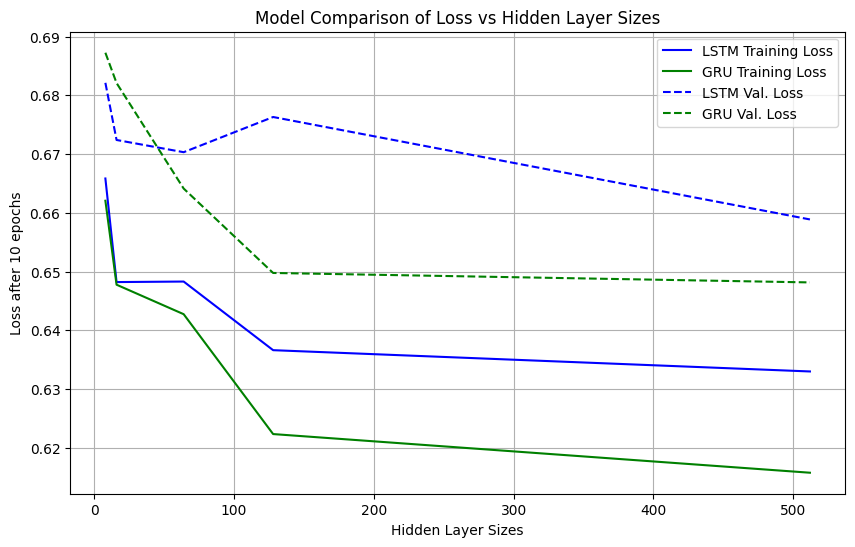

In [25]:
## hidden sizes- Hyperparameter tuning
import matplotlib.pyplot as plt


# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
hidden = [8, 16, 64, 128, 512]
for i in hidden:
  # Define the training hyperparameters and model
  input_dim = len(TEXT.vocab)
  embedding_dim = 200
  hidden_dim = i
  output_dim = 1


  #model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  #model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)


  # Adam optimizer
  optimizer = optim.Adam(model.parameters())
  optimizer2 = optim.Adam(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()
  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))
plt.plot(hidden, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(hidden, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(hidden, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(hidden, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Hidden Layer Sizes')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Testing: Hidden Layer sizes


Here the final loss of each model is recorded for each layer size. It appears that the performance improves as the hidden layer sizes increases. This could be due to allowing it to find more complex patterns. However, it maybe overfitting since there is a significant difference in the valid error as compared to the training error, but the improvement still exists in the valid error as the hidden layer size increases. As has been the cases, the GRU model performs better than the LSTM model.

In [ ]:
## Embedding dimensions- Hyperparameter tuning
import matplotlib.pyplot as plt


# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
hidden = [50, 100, 150, 200, 250, 300]
for i in hidden:
  # Define the training hyperparameters and model
  input_dim = len(TEXT.vocab)
  embedding_dim = i
  hidden_dim = 128
  output_dim = 1


  #model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  #model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)


  # Adam optimizer
  optimizer = optim.Adam(model.parameters())
  optimizer2 = optim.Adam(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()
  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))
plt.plot(hidden, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(hidden, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(hidden, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(hidden, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Embedded Dimensions')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Embedded Dimensions')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Testing: Embedded Dimensions


Here the final loss of each model is recorded for each embedded dimension.

In [26]:
## Learning rate - Hyperparameter tuning
import matplotlib.pyplot as plt


# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Define the training hyperparameters and model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 128
output_dim = 1


#model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)

lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
lrs = [0.1, 0.01, 0.001, 0.0001]
for i in lrs:
  # Adam optimizer
  optimizer = optim.Adam(model.parameters(), lr = i)
  optimizer2 = optim.Adam(model2.parameters(), lr = i)
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()
  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))
plt.plot(lrs , lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(lrs , lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(lrs , lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(lrs , lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

TypeError: '<=' not supported between instances of 'float' and 'list'

### Hyperparameter Testing: Learning Rate


Here the final loss of each model is recorded for each learning rate.

In [ ]:
#Optimizers- Hyperparameter tuning
import matplotlib.pyplot as plt


# Define the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    device=device
)

# Define the training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    iterator.create_batches()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_len = batch.text
        predictions = model(text, text_len).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    iterator.create_batches()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text
            predictions = model(text, text_len).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the training hyperparameters and model
input_dim = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 128
output_dim = 1


#model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
#model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
nums = [0,1]
for i in nums:
  if i == 0:
    # Adam optimizer
    optimizer = optim.Adam(model.parameters())
    optimizer2 = optim.Adam(model2.parameters())
  else:
    optimizer = optim.SGD(model.parameters())
    optimizer2 = optim.SGD(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()
  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))

plt.plot(nums, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(nums, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(nums, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(nums, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('Two optimizers')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Optimizers Adam and SGD')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Testing: Optimizer


Here the final loss of each model is recorded for the adam optimizer and the SGD optimizer.

In [ ]:
#Embeddings -Compare model performance with and without pretrained embeddings (e.g., GloVe or Word2Vec). Using Glove
import matplotlib.pyplot as plt


lossGRU = []
lossGRUVal = []
lossLSTM = []
lossLSTMVal = []
num = [0,1]
for i in num:
  # Define the device (GPU if available, else CPU)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  #embeddings
  MAX_VOCAB_SIZE = 25000
  TEXT.build_vocab(train_data,
                  max_size = MAX_VOCAB_SIZE,
                  vectors = "glove.6B.100d",
                  unk_init = torch.Tensor.normal_)

  LABEL.build_vocab(train_data)
  # Define the iterators
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data),
      batch_size=64,
      sort_within_batch=True,
      device=device
  )

  # Define the training loop
  def train(model, iterator, optimizer, criterion):
      model.train()
      epoch_loss = 0
      iterator.create_batches()
      for batch in iterator:
          optimizer.zero_grad()
          text, text_len = batch.text
          predictions = model(text, text_len).squeeze(1)
          loss = criterion(predictions, batch.label)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      return epoch_loss / len(iterator)

  # Define the evaluation function
  def evaluate(model, iterator, criterion):
      model.eval()
      epoch_loss = 0
      iterator.create_batches()
      with torch.no_grad():
          for batch in iterator:
              text, text_len = batch.text
              predictions = model(text, text_len).squeeze(1)
              loss = criterion(predictions, batch.label)
              epoch_loss += loss.item()
      return epoch_loss / len(iterator)

  # Define the training hyperparameters and model
  input_dim = len(TEXT.vocab)
  embedding_dim = 200
  hidden_dim = 128
  output_dim = 1


  #model = FCNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  #model = RNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
  model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)




  optimizer = optim.Adam(model.parameters())
  optimizer2 = optim.Adam(model2.parameters())
  #Binary Cross Entropy Loss With Sigmoid Function for stable binary classification
  criterion = nn.BCEWithLogitsLoss()
  # Train and evaluate the model
  N_EPOCHS = 10
  for epoch in range(N_EPOCHS):
      train_loss = train(model, train_iterator, optimizer, criterion)
      valid_loss = evaluate(model, valid_iterator, criterion)
      train_loss2 = train(model2, train_iterator, optimizer2, criterion)
      valid_loss2 = evaluate(model2, valid_iterator, criterion)
      #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


  ##Capture final loss
  lossGRU.append(train_loss)
  lossGRUVal.append(valid_loss)
  lossLSTM.append(train_loss2)
  lossLSTMVal.append(valid_loss2)
  # Test the model
  '''test_loss = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')'''

plt.figure(figsize=(10, 6))

plt.plot(num, lossLSTM, linestyle='-', color='b', label='LSTM Training Loss')
plt.plot(num, lossGRU, linestyle='-', color='g', label='GRU Training Loss')
plt.plot(num, lossLSTMVal, linestyle='--', color='b', label='LSTM Val. Loss')
plt.plot(num, lossGRUVal, linestyle='--', color='g', label='GRU Val. Loss')
plt.xlabel('With/out Embeddings')
plt.ylabel('Loss after 10 epochs')
plt.title('Model Comparison of Loss vs Embeddings')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Testing: Embedding changes


Here the final loss of each model is recorded for with and without an embedding.

### For the pretrained embeddings

There are several ways of doing this:

--------
#### One way

Download the pretrained word2vec embeddings.
- NOTE: You can use popular pretrained word embeddings like Word2Vec from gensim, GloVe, or FastText. (e.g. https://radimrehurek.com/gensim/models/word2vec.html)
- See a tutorial fro using Glove here (but you can use the same approach for word2vec): https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

Load the pretrained word2vec embeddings into a dictionary, where the keys are words, and the values are the corresponding embedding vectors.

As you read your input, use the dictionary to retrieve the embedding

Pass the embeddinngs directly as input to the NN model

--------

#### Easy way

torchtext.vocab has pretrained embeddings for GloVe, FastText, CharNGram
- https://pytorch.org/text/stable/vocab.html
- https://torchtext.readthedocs.io/en/latest/vocab.html

You'd use it like this:


```
TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)
```

100d indicates that the pretrained vectors are of size 100, so make sure to adjust the network dimensions


## To reverse the vectors into tokens

- https://anie.me/On-Torchtext/



# Turn this in

# Chose two of the models provided above and do the following:

### Hyperparameter tuning:

- Experiment with different hyperparameters such as learning rate, embedding dimensions, hidden dimensions, number of layers, and batch sizes. Observe the impact on training and validation performance. Plot the losses as a function of number of epochs

- Try different optimizers (e.g., SGD, AdamW) and compare their performance.

### Embedding Layer:

- Experiment with pre-trained word embeddings (e.g., Word2Vec, GloVe). Use these pre-trained embeddings as the initial input of the embedding layer.

- Compare the results of the model with the original embedding layer vs pretrained embeddings.


### Error Analysis:

- Analyze misclassified examples to gain insights into the model's weaknesses. Show examples and write your insights regarding the problems of the network.


### For every aspect of the lab, make sure to plot the results and write your observations.
